In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss
from scipy.special import expit

from ampligraph.datasets import load_wn18rr
from ampligraph.latent_features.models import TransE, ComplEx

In [40]:
from generate_corruptions import generate_corruptions, calibration_loss, pos_iso

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
X = load_wn18rr()

In [36]:
import types
from functools import partial
import tensorflow as tf
from sklearn.utils import check_random_state
from tqdm import tqdm
from ampligraph.datasets import AmpligraphDatasetAdapter, NumpyDatasetAdapter
from ampligraph.evaluation import generate_corruptions_for_fit, to_idx, generate_corruptions_for_eval, \
    hits_at_n_score, mrr_score


def generate_corruptions_triples(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        batch_size_pos = int(np.ceil(dataset_handle.get_size("pos") / batches_count))

        gen_fn = partial(dataset_handle.get_next_batch, batches_count=batches_count, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(x_neg_tf))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        print(e)
        dataset_handle.cleanup()

In [24]:
def pos_iso(cal_model, pos_scores, neg_scores, positive_base_rate):
    weigths_pos = len(neg_scores) / len(pos_scores)
    weights_neg = (1.0 - positive_base_rate) / positive_base_rate
    weights = np.concatenate((np.full(pos_scores.shape, weigths_pos),
                              np.full(neg_scores.shape, weights_neg))).astype(float)
    target =  np.concatenate((np.ones(pos_scores.shape), np.zeros(neg_scores.shape))).astype(float)
    x = np.concatenate((pos_scores, neg_scores)).astype(float)
    
    cal_model.fit(x, target, sample_weight=weights)
    return cal_model

In [6]:
model = ComplEx(batches_count=10, seed=0, epochs=4000, k=200, eta=20,
                # Use adam optimizer with learning rate 1e-3
                optimizer='adam', optimizer_params={'lr':0.0005},
                # Use pairwise loss with margin 0.5
                loss='multiclass_nll',
                # Use L2 regularizer with regularizer weight 1e-5
                regularizer='LP', regularizer_params={'p':3, 'lambda':0.05}, 
                # Enable stdout messages (set to false if you don't want to display)
                verbose=True)

filter_triples = np.concatenate((X['train'], X['valid'], X['test']))

# Fit the model on training and validation set
model.fit(X['train'], 
          early_stopping = True,
          early_stopping_params = \
                  {
                      'x_valid': X['valid'],       # validation set
                      'criteria':'mrr',         # Uses hits10 criteria for early stopping
                      'burn_in': 100,              # early stopping kicks in after 100 epochs
                      'check_interval':100,         # validates every 20th epoch
                      'stop_interval':2,           # stops if 5 successive validation checks are bad.
                      'x_filter': filter_triples,          # Use filter for filtering out positives 
                      'corruption_entities':'all', # corrupt using all entities
                      'corrupt_side':'s+o'         # corrupt subject and object (but not at once)
                  }
          )



WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabacof/.

Average Loss:   0.150882 — Best validation (mrr): 0.441295:  35%|███▍      | 1399/4000 [16:17<21:13,  2.04epoch/s]  

In [7]:
ranks = evaluate_performance(X['test'], 
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True, 
                             verbose=False)


100%|██████████| 2924/2924 [00:23<00:00, 124.67it/s]

In [8]:
mrr_score(ranks),  hits_at_n_score(ranks, n=10), mr_score(ranks)

(0.5059065017035501, 0.5827633378932968, 4110.8835499316)

In [37]:
model.generate_corruptions_triples = types.MethodType(generate_corruptions_triples, model)
fake_negatives = model.generate_corruptions_triples(X['test'], batches_count=10, epochs=1000)


100%|██████████| 1000/1000 [00:17<00:00, 57.68epoch/s]

In [38]:
idx_to_ent = {v: k for k, v in model.ent_to_idx.items()} 
idx_to_rel = {v: k for k, v in model.rel_to_idx.items()} 

In [44]:
results = []

for pbr in np.linspace(0.05, 0.95, 19):
    
    fake_idx = np.random.randint(len(fake_negatives), size=int(len(X['test'])/pbr-len(X['test'])))
    fake_test = fake_negatives[fake_idx, :]

    s = np.vectorize(idx_to_ent.get)(fake_test[:, 0])
    p = np.vectorize(idx_to_rel.get)(fake_test[:, 1])
    o = np.vectorize(idx_to_ent.get)(fake_test[:, 2])

    fake_test = np.vstack((s, p, o)).T
    X_test = np.vstack((X['test'], fake_test))
    X_test_labels = np.concatenate((np.ones(len(X['test'])), np.zeros(len(fake_idx))))
    
    scores = model.predict(X_test)

    model.calibrate(X['valid'], batches_count=10, epochs=1000, positive_base_rate=pbr)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X_test)

    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X['valid'], batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X['valid']))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=pbr)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=pbr)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))

    results.append({
        'pbr': pbr,
        'brier_score_baseline': brier_score_loss(X_test_labels, np.array([pbr]*len(X_test_labels))),
        'log_loss_baseline': log_loss(X_test_labels, np.array([pbr]*len(X_test_labels)), eps=1e-7),
        'brier_score_scores': brier_score_loss(X_test_labels, expit(scores)),
        'log_loss_scores': log_loss(X_test_labels, expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X_test_labels, probas1),
        'log_loss_probas_pos': log_loss(X_test_labels, probas1, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X_test_labels, probas4),
        'log_loss_probas_pos_iso': log_loss(X_test_labels, probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X_test_labels, probas5),
        'log_loss_probas_pos_sc': log_loss(X_test_labels, probas5, eps=1e-7),
        'ece_scores': calibration_loss(X_test_labels, expit(scores)),
        'ece_probas_pos': calibration_loss(X_test_labels, probas1),
        'ece_probas_pos_iso': calibration_loss(X_test_labels, probas4),
        'ece_probas_pos_sc': calibration_loss(X_test_labels, probas5),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks)
    })
        
    print(json.dumps(results[-1], indent=2))


Calibration Loss:   2.865577:  14%|█▍        | 139/1000 [00:06<00:37, 22.80epoch/s]


Calibration Loss:   1.587014:  28%|██▊       | 280/1000 [00:12<00:29, 24.14epoch/s]


Calibration Loss:   1.143370:  42%|████▏     | 421/1000 [00:18<00:23, 24.36epoch/s]


Calibration Loss:   0.939238:  56%|█████▌    | 562/1000 [00:24<00:18, 23.47epoch/s]


Calibration Loss:   0.891951:  70%|███████   | 703/1000 [00:29<00:12, 24.17epoch/s]


Calibration Loss:   0.878873:  84%|████████▍ | 844/1000 [00:35<00:06, 24.43epoch/s]


Calibration Loss:   0.822277:  98%|█████████▊| 985/1000 [00:41<00:00, 24.68epoch/s]


Calibration Loss:   0.899372: 100%|██████████| 1000/1000 [00:41<00:00, 24.01epoch/s]

pos [-1.8881925, 4.278492]



100%|██████████| 1000/1000 [00:24<00:00, 47.87epoch/s]

pos sc -1.3770990308821143 4.196302856558583
{
  "pbr": 0.05,
  "brier_score_baseline": 0.0475,
  "log_loss_baseline": 0.19851524334587262,
  "brier_score_scores": 0.2569135029973487,
  "log_loss_scores": 0.7130623417005014,
  "brier_score_probas_pos": 0.020477247602880087,
  "log_loss_probas_pos": 0.09968673579507568,
  "brier_score_probas_pos_iso": 0.020260817194797318,
  "log_loss_probas_pos_iso": 0.09310155030818588,
  "brier_score_probas_pos_sc": 0.020649825640045933,
  "log_loss_probas_pos_sc": 0.09552777745581605,
  "ece_scores": 0.46913707683578887,
  "ece_probas_pos": 0.0063115064487900855,
  "ece_probas_pos_iso": 0.0017440878874268118,
  "ece_probas_pos_sc": 0.005520415358776602,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count

Calibration Loss:   1.519499:  14%|█▎        | 136/1000 [00:06<00:37, 22.90epoch/s]


Calibration Loss:   0.965441:  28%|██▊       | 277/1000 [00:12<00:31, 23.08epoch/s]


Calibration Loss:   0.783204:  42%|████▏     | 420/1000 [00:18<00:25, 22.87epoch/s]


Calibration Loss:   0.715347:  56%|█████▌    | 561/1000 [00:24<00:18, 23.59epoch/s]


Calibration Loss:   0.712138:  70%|███████   | 701/1000 [00:30<00:12, 23.66epoch/s]


Calibration Loss:   0.699414:  84%|████████▍ | 844/1000 [00:36<00:06, 22.60epoch/s]


Calibration Loss:   0.673063:  98%|█████████▊| 984/1000 [00:41<00:00, 25.39epoch/s]


Calibration Loss:   0.718131: 100%|██████████| 1000/1000 [00:42<00:00, 23.55epoch/s]

pos [-2.011764, 3.6529825]



100%|██████████| 1000/1000 [00:22<00:00, 45.30epoch/s]

pos sc -1.4729086411744414 3.5221600110570677
{
  "pbr": 0.1,
  "brier_score_baseline": 0.09000000000000004,
  "log_loss_baseline": 0.3250829733914482,
  "brier_score_scores": 0.24564914923019066,
  "log_loss_scores": 0.6841802084219234,
  "brier_score_probas_pos": 0.03672746790129954,
  "log_loss_probas_pos": 0.16076814469740272,
  "brier_score_probas_pos_iso": 0.03629048072122839,
  "log_loss_probas_pos_iso": 0.1522587873947423,
  "brier_score_probas_pos_sc": 0.0363934811771447,
  "log_loss_probas_pos_sc": 0.15438353825433224,
  "ece_scores": 0.43542060438650576,
  "ece_probas_pos": 0.008028069533988652,
  "ece_probas_pos_iso": 0.004955106451697737,
  "ece_probas_pos_sc": 0.005237158844670756,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   1.029810:  14%|█▍        | 141/1000 [00:06<00:33, 25.57epoch/s]


Calibration Loss:   0.731491:  28%|██▊       | 280/1000 [00:11<00:30, 23.74epoch/s]


Calibration Loss:   0.658422:  42%|████▏     | 424/1000 [00:17<00:25, 22.81epoch/s]


Calibration Loss:   0.627332:  56%|█████▋    | 565/1000 [00:23<00:17, 25.51epoch/s]


Calibration Loss:   0.644581:  70%|███████   | 705/1000 [00:29<00:12, 23.02epoch/s]


Calibration Loss:   0.625594:  85%|████████▍ | 849/1000 [00:35<00:06, 24.12epoch/s]


Calibration Loss:   0.603080:  99%|█████████▉| 989/1000 [00:41<00:00, 26.01epoch/s]


Calibration Loss:   0.622359: 100%|██████████| 1000/1000 [00:41<00:00, 23.99epoch/s]

pos [-2.024087, 3.216479]



100%|██████████| 1000/1000 [00:22<00:00, 43.89epoch/s]

pos sc -1.516372426676851 3.0945275127815286
{
  "pbr": 0.15,
  "brier_score_baseline": 0.1275017955163392,
  "log_loss_baseline": 0.42271353709818665,
  "brier_score_scores": 0.23610585723946673,
  "log_loss_scores": 0.6598495397764245,
  "brier_score_probas_pos": 0.05081738409657569,
  "log_loss_probas_pos": 0.21103937816615667,
  "brier_score_probas_pos_iso": 0.05035186546572356,
  "log_loss_probas_pos_iso": 0.19961702723738853,
  "brier_score_probas_pos_sc": 0.05049452791224129,
  "log_loss_probas_pos_sc": 0.20366834395311562,
  "ece_scores": 0.4036080766248891,
  "ece_probas_pos": 0.009338745640086545,
  "ece_probas_pos_iso": 0.007077199715430446,
  "ece_probas_pos_sc": 0.00700920141764707,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.797753:  14%|█▍        | 141/1000 [00:06<00:36, 23.49epoch/s]


Calibration Loss:   0.611619:  28%|██▊       | 281/1000 [00:12<00:31, 23.05epoch/s]


Calibration Loss:   0.552544:  42%|████▏     | 422/1000 [00:18<00:23, 24.83epoch/s]


Calibration Loss:   0.559924:  56%|█████▋    | 565/1000 [00:23<00:18, 23.50epoch/s]


Calibration Loss:   0.572553:  70%|███████   | 705/1000 [00:29<00:11, 24.85epoch/s]


Calibration Loss:   0.560264:  85%|████████▍ | 848/1000 [00:35<00:06, 23.70epoch/s]


Calibration Loss:   0.543002:  99%|█████████▉| 989/1000 [00:41<00:00, 24.43epoch/s]


Calibration Loss:   0.556809: 100%|██████████| 1000/1000 [00:41<00:00, 24.14epoch/s]

pos [-2.012196, 2.876802]



100%|██████████| 1000/1000 [00:20<00:00, 47.86epoch/s]

pos sc -1.5381140831386055 2.76609735644041
{
  "pbr": 0.2,
  "brier_score_baseline": 0.16000000000000011,
  "log_loss_baseline": 0.5004024235381878,
  "brier_score_scores": 0.22764491036823747,
  "log_loss_scores": 0.6360238880265009,
  "brier_score_probas_pos": 0.06425196848130599,
  "log_loss_probas_pos": 0.25101409245495276,
  "brier_score_probas_pos_iso": 0.06365689259833678,
  "log_loss_probas_pos_iso": 0.24032158362011072,
  "brier_score_probas_pos_sc": 0.0636655424786392,
  "log_loss_probas_pos_sc": 0.24301293177102382,
  "ece_scores": 0.3728159330041236,
  "ece_probas_pos": 0.016054388012344635,
  "ece_probas_pos_iso": 0.007946948039397154,
  "ece_probas_pos_sc": 0.005353419831420465,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count

Calibration Loss:   0.666436:  14%|█▍        | 138/1000 [00:06<00:37, 23.21epoch/s]


Calibration Loss:   0.537506:  28%|██▊       | 279/1000 [00:12<00:31, 22.88epoch/s]


Calibration Loss:   0.505659:  42%|████▏     | 419/1000 [00:18<00:26, 22.28epoch/s]


Calibration Loss:   0.492813:  56%|█████▋    | 563/1000 [00:24<00:18, 23.03epoch/s]


Calibration Loss:   0.497461:  70%|███████   | 704/1000 [00:30<00:12, 24.15epoch/s]


Calibration Loss:   0.498287:  84%|████████▍ | 844/1000 [00:36<00:06, 24.90epoch/s]


Calibration Loss:   0.500630:  99%|█████████▉| 988/1000 [00:41<00:00, 24.88epoch/s]


Calibration Loss:   0.506349: 100%|██████████| 1000/1000 [00:42<00:00, 24.03epoch/s]

pos [-1.9920297, 2.5915241]



100%|██████████| 1000/1000 [00:21<00:00, 47.07epoch/s]

pos sc -1.5483696928323547 2.4905486942728725
{
  "pbr": 0.25,
  "brier_score_baseline": 0.1875,
  "log_loss_baseline": 0.5623351446188082,
  "brier_score_scores": 0.21611461733384824,
  "log_loss_scores": 0.6042092408545903,
  "brier_score_probas_pos": 0.07484292508375259,
  "log_loss_probas_pos": 0.2787169958510443,
  "brier_score_probas_pos_iso": 0.07429229564231792,
  "log_loss_probas_pos_iso": 0.270473948715686,
  "brier_score_probas_pos_sc": 0.07450866361109458,
  "log_loss_probas_pos_sc": 0.27243750754900636,
  "ece_scores": 0.3387977311084437,
  "ece_probas_pos": 0.019243362990351946,
  "ece_probas_pos_iso": 0.010465589055948084,
  "ece_probas_pos_sc": 0.011546279557329855,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.564571:  14%|█▍        | 139/1000 [00:06<00:37, 22.86epoch/s]


Calibration Loss:   0.474830:  28%|██▊       | 280/1000 [00:12<00:29, 24.32epoch/s]


Calibration Loss:   0.462655:  42%|████▏     | 421/1000 [00:17<00:23, 24.70epoch/s]


Calibration Loss:   0.454527:  56%|█████▌    | 562/1000 [00:23<00:18, 24.33epoch/s]


Calibration Loss:   0.457313:  70%|███████   | 703/1000 [00:29<00:12, 23.95epoch/s]


Calibration Loss:   0.458263:  84%|████████▍ | 844/1000 [00:34<00:06, 24.72epoch/s]


Calibration Loss:   0.451076:  98%|█████████▊| 985/1000 [00:40<00:00, 24.33epoch/s]


Calibration Loss:   0.464736: 100%|██████████| 1000/1000 [00:41<00:00, 24.30epoch/s]

pos [-1.9676937, 2.3393927]



100%|██████████| 1000/1000 [00:24<00:00, 51.90epoch/s]

pos sc -1.5515755869462287 2.2468182632592906
{
  "pbr": 0.3,
  "brier_score_baseline": 0.21000820849579316,
  "log_loss_baseline": 0.6108816896571998,
  "brier_score_scores": 0.2054061562035796,
  "log_loss_scores": 0.5741595621208427,
  "brier_score_probas_pos": 0.08471012039757167,
  "log_loss_probas_pos": 0.30012637967361155,
  "brier_score_probas_pos_iso": 0.08426885927220192,
  "log_loss_probas_pos_iso": 0.29530792322944344,
  "brier_score_probas_pos_sc": 0.08424354576672537,
  "log_loss_probas_pos_sc": 0.29575064889151276,
  "ece_scores": 0.30642418920834796,
  "ece_probas_pos": 0.021644381705725822,
  "ece_probas_pos_iso": 0.01138660216046583,
  "ece_probas_pos_sc": 0.016567469769002117,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.497520:  14%|█▍        | 139/1000 [00:06<00:34, 24.84epoch/s]


Calibration Loss:   0.434633:  28%|██▊       | 281/1000 [00:12<00:30, 23.48epoch/s]


Calibration Loss:   0.436013:  42%|████▏     | 421/1000 [00:18<00:23, 24.21epoch/s]


Calibration Loss:   0.429446:  56%|█████▋    | 564/1000 [00:24<00:19, 22.93epoch/s]


Calibration Loss:   0.424288:  70%|███████   | 704/1000 [00:30<00:13, 22.07epoch/s]


Calibration Loss:   0.421315:  85%|████████▍ | 848/1000 [00:36<00:06, 23.74epoch/s]


Calibration Loss:   0.422695:  99%|█████████▉| 988/1000 [00:42<00:00, 25.28epoch/s]


Calibration Loss:   0.428800: 100%|██████████| 1000/1000 [00:42<00:00, 25.57epoch/s]

pos [-1.9405862, 2.1083357]



100%|██████████| 1000/1000 [00:23<00:00, 48.12epoch/s]

pos sc -1.549903441032382 2.023131732521102
{
  "pbr": 0.35,
  "brier_score_baseline": 0.2275035910940867,
  "log_loss_baseline": 0.6474540491281017,
  "brier_score_scores": 0.1966108164111419,
  "log_loss_scores": 0.5508799960098628,
  "brier_score_probas_pos": 0.094927696485206,
  "log_loss_probas_pos": 0.32716232974680176,
  "brier_score_probas_pos_iso": 0.09415816315079066,
  "log_loss_probas_pos_iso": 0.3205835654574433,
  "brier_score_probas_pos_sc": 0.0943800013464759,
  "log_loss_probas_pos_sc": 0.3216443009877114,
  "ece_scores": 0.2745661704283968,
  "ece_probas_pos": 0.028454500435355846,
  "ece_probas_pos_iso": 0.01153316373102522,
  "ece_probas_pos_sc": 0.019974449809307234,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.446841:  14%|█▍        | 140/1000 [00:06<00:33, 25.77epoch/s]


Calibration Loss:   0.406663:  28%|██▊       | 280/1000 [00:12<00:32, 22.50epoch/s]


Calibration Loss:   0.402854:  42%|████▏     | 421/1000 [00:18<00:24, 23.95epoch/s]


Calibration Loss:   0.397437:  56%|█████▌    | 562/1000 [00:24<00:17, 24.46epoch/s]


Calibration Loss:   0.390584:  70%|███████   | 703/1000 [00:29<00:12, 24.21epoch/s]


Calibration Loss:   0.391892:  84%|████████▍ | 844/1000 [00:35<00:06, 25.08epoch/s]


Calibration Loss:   0.393559:  98%|█████████▊| 985/1000 [00:41<00:00, 25.13epoch/s]


Calibration Loss:   0.396701: 100%|██████████| 1000/1000 [00:41<00:00, 23.89epoch/s]

pos [-1.9112058, 1.8905946]



100%|██████████| 1000/1000 [00:23<00:00, 42.12epoch/s]

pos sc -1.54453465986412 1.8120003063227192
{
  "pbr": 0.39999999999999997,
  "brier_score_baseline": 0.24000000000000005,
  "log_loss_baseline": 0.6730116670092565,
  "brier_score_scores": 0.18658690579665027,
  "log_loss_scores": 0.5286832432856411,
  "brier_score_probas_pos": 0.10345821450346797,
  "log_loss_probas_pos": 0.3537660764183056,
  "brier_score_probas_pos_iso": 0.10275174231891945,
  "log_loss_probas_pos_iso": 0.3423165516193182,
  "brier_score_probas_pos_sc": 0.10299333998411078,
  "log_loss_probas_pos_sc": 0.34674156909505366,
  "ece_scores": 0.24279532508386958,
  "ece_probas_pos": 0.029478575136364742,
  "ece_probas_pos_iso": 0.01430603057583058,
  "ece_probas_pos_sc": 0.024668995093299517,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.406739:  14%|█▍        | 141/1000 [00:05<00:35, 24.43epoch/s]


Calibration Loss:   0.376046:  28%|██▊       | 281/1000 [00:11<00:31, 22.84epoch/s]


Calibration Loss:   0.372649:  42%|████▏     | 422/1000 [00:17<00:25, 22.86epoch/s]


Calibration Loss:   0.370041:  56%|█████▋    | 563/1000 [00:23<00:18, 24.10epoch/s]


Calibration Loss:   0.364199:  71%|███████   | 706/1000 [00:29<00:12, 23.11epoch/s]


Calibration Loss:   0.362371:  85%|████████▍ | 848/1000 [00:35<00:06, 22.91epoch/s]


Calibration Loss:   0.363229:  99%|█████████▉| 989/1000 [00:41<00:00, 26.27epoch/s]


Calibration Loss:   0.367259: 100%|██████████| 1000/1000 [00:41<00:00, 23.89epoch/s]

pos [-1.8796391, 1.6805784]



100%|██████████| 1000/1000 [00:21<00:00, 46.67epoch/s]

pos sc -1.5360812814094091 1.6080503904669132
{
  "pbr": 0.44999999999999996,
  "brier_score_baseline": 0.24750538710173933,
  "log_loss_baseline": 0.688149624048114,
  "brier_score_scores": 0.17767326251029308,
  "log_loss_scores": 0.5029641765135376,
  "brier_score_probas_pos": 0.11105586189732829,
  "log_loss_probas_pos": 0.366134837227367,
  "brier_score_probas_pos_iso": 0.11026079303026048,
  "log_loss_probas_pos_iso": 0.3572165697114025,
  "brier_score_probas_pos_sc": 0.11038354076935826,
  "log_loss_probas_pos_sc": 0.35975100986840813,
  "ece_scores": 0.21284090067141423,
  "ece_probas_pos": 0.02562580810283831,
  "ece_probas_pos_iso": 0.015145465808051503,
  "ece_probas_pos_sc": 0.018995784204800584,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.373300:  14%|█▍        | 139/1000 [00:06<00:34, 24.60epoch/s]


Calibration Loss:   0.343705:  28%|██▊       | 280/1000 [00:11<00:29, 24.31epoch/s]


Calibration Loss:   0.340239:  42%|████▏     | 421/1000 [00:17<00:23, 24.38epoch/s]


Calibration Loss:   0.334974:  56%|█████▌    | 562/1000 [00:23<00:17, 24.60epoch/s]


Calibration Loss:   0.335788:  70%|███████   | 703/1000 [00:29<00:12, 24.36epoch/s]


Calibration Loss:   0.336608:  84%|████████▍ | 844/1000 [00:34<00:06, 24.41epoch/s]


Calibration Loss:   0.333906:  98%|█████████▊| 985/1000 [00:40<00:00, 23.20epoch/s]


Calibration Loss:   0.339649: 100%|██████████| 1000/1000 [00:41<00:00, 22.79epoch/s]

pos [-1.8457189, 1.4737699]



100%|██████████| 1000/1000 [00:23<00:00, 43.17epoch/s]

pos sc -1.524737074792511 1.4068707969082141
{
  "pbr": 0.49999999999999994,
  "brier_score_baseline": 0.25,
  "log_loss_baseline": 0.6931471805599454,
  "brier_score_scores": 0.16515098294754205,
  "log_loss_scores": 0.47032571615886404,
  "brier_score_probas_pos": 0.11491480525794276,
  "log_loss_probas_pos": 0.37017771655052983,
  "brier_score_probas_pos_iso": 0.11392801081466236,
  "log_loss_probas_pos_iso": 0.3628289519269122,
  "brier_score_probas_pos_sc": 0.11462263716960298,
  "log_loss_probas_pos_sc": 0.3651251041622092,
  "ece_scores": 0.177779143520729,
  "ece_probas_pos": 0.02843465231022656,
  "ece_probas_pos_iso": 0.012784395740466704,
  "ece_probas_pos_sc": 0.026384365492166398,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.343895:  14%|█▍        | 141/1000 [00:06<00:37, 22.86epoch/s]


Calibration Loss:   0.320648:  28%|██▊       | 281/1000 [00:12<00:30, 23.71epoch/s]


Calibration Loss:   0.310906:  42%|████▏     | 422/1000 [00:18<00:23, 25.06epoch/s]


Calibration Loss:   0.315706:  56%|█████▋    | 563/1000 [00:24<00:18, 24.09epoch/s]


Calibration Loss:   0.311150:  71%|███████   | 707/1000 [00:29<00:12, 23.17epoch/s]


Calibration Loss:   0.316074:  85%|████████▍ | 848/1000 [00:35<00:05, 26.20epoch/s]


Calibration Loss:   0.310539:  99%|█████████▉| 990/1000 [00:41<00:00, 22.60epoch/s]


Calibration Loss:   0.313248: 100%|██████████| 1000/1000 [00:42<00:00, 23.75epoch/s]

pos [-1.8092748, 1.2661253]



100%|██████████| 1000/1000 [00:22<00:00, 44.67epoch/s]

pos sc -1.5106515063512556 1.2045286843716763
{
  "pbr": 0.5499999999999999,
  "brier_score_baseline": 0.24749623777276145,
  "log_loss_baseline": 0.688131264026024,
  "brier_score_scores": 0.15466405389348373,
  "log_loss_scores": 0.44301181653830657,
  "brier_score_probas_pos": 0.11892423402708979,
  "log_loss_probas_pos": 0.3748346266040392,
  "brier_score_probas_pos_iso": 0.11822505337672563,
  "log_loss_probas_pos_iso": 0.36922454585828346,
  "brier_score_probas_pos_sc": 0.11855297417142066,
  "log_loss_probas_pos_sc": 0.37001299409319455,
  "ece_scores": 0.14770541467372414,
  "ece_probas_pos": 0.03024158879632426,
  "ece_probas_pos_iso": 0.014080772046979073,
  "ece_probas_pos_sc": 0.023933044974330926,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.316309:  14%|█▍        | 139/1000 [00:06<00:35, 24.33epoch/s]


Calibration Loss:   0.291261:  28%|██▊       | 280/1000 [00:11<00:29, 24.37epoch/s]


Calibration Loss:   0.288649:  42%|████▏     | 421/1000 [00:17<00:22, 25.21epoch/s]


Calibration Loss:   0.284292:  56%|█████▌    | 562/1000 [00:23<00:18, 24.24epoch/s]


Calibration Loss:   0.284811:  70%|███████   | 703/1000 [00:29<00:11, 24.99epoch/s]


Calibration Loss:   0.285523:  84%|████████▍ | 844/1000 [00:34<00:06, 24.48epoch/s]


Calibration Loss:   0.283877:  98%|█████████▊| 985/1000 [00:41<00:00, 23.08epoch/s]


Calibration Loss:   0.287540: 100%|██████████| 1000/1000 [00:41<00:00, 23.07epoch/s]

pos [-1.7695727, 1.0534258]



100%|██████████| 1000/1000 [00:24<00:00, 40.54epoch/s]

pos sc -1.493668150181663 0.9969777979700525
{
  "pbr": 0.6,
  "brier_score_baseline": 0.23999179150420685,
  "log_loss_baseline": 0.6729950257160854,
  "brier_score_scores": 0.14511421593396387,
  "log_loss_scores": 0.41691797754214643,
  "brier_score_probas_pos": 0.12164182825158223,
  "log_loss_probas_pos": 0.3744565284701912,
  "brier_score_probas_pos_iso": 0.1208439964818938,
  "log_loss_probas_pos_iso": 0.3703860674836264,
  "brier_score_probas_pos_sc": 0.12114450908578957,
  "log_loss_probas_pos_sc": 0.37002386426894923,
  "ece_scores": 0.11693943280741204,
  "ece_probas_pos": 0.028292013442714467,
  "ece_probas_pos_iso": 0.01747094769224604,
  "ece_probas_pos_sc": 0.02262000979832573,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.289184:  14%|█▍        | 141/1000 [00:06<00:36, 23.61epoch/s]


Calibration Loss:   0.268770:  28%|██▊       | 282/1000 [00:11<00:28, 25.03epoch/s]


Calibration Loss:   0.265254:  42%|████▏     | 423/1000 [00:17<00:25, 22.60epoch/s]


Calibration Loss:   0.264103:  56%|█████▋    | 564/1000 [00:23<00:18, 23.65epoch/s]


Calibration Loss:   0.260640:  71%|███████   | 706/1000 [00:29<00:12, 23.15epoch/s]


Calibration Loss:   0.260019:  85%|████████▍ | 848/1000 [00:35<00:06, 22.51epoch/s]


Calibration Loss:   0.260254:  99%|█████████▉| 988/1000 [00:41<00:00, 23.56epoch/s]


Calibration Loss:   0.262056: 100%|██████████| 1000/1000 [00:42<00:00, 22.83epoch/s]

pos [-1.7258769, 0.83089215]



100%|██████████| 1000/1000 [00:22<00:00, 44.60epoch/s]

pos sc -1.4732624762866278 0.7794529195412432
{
  "pbr": 0.65,
  "brier_score_baseline": 0.22747999110715872,
  "log_loss_baseline": 0.647405351404014,
  "brier_score_scores": 0.13559397977079574,
  "log_loss_scores": 0.3916990171723484,
  "brier_score_probas_pos": 0.1214367653776899,
  "log_loss_probas_pos": 0.3684723714982512,
  "brier_score_probas_pos_iso": 0.11998000213444884,
  "log_loss_probas_pos_iso": 0.3630374864578236,
  "brier_score_probas_pos_sc": 0.12101498990370722,
  "log_loss_probas_pos_sc": 0.36486253826437715,
  "ece_scores": 0.09244491477286143,
  "ece_probas_pos": 0.028655425979593915,
  "ece_probas_pos_iso": 0.019065729329161927,
  "ece_probas_pos_sc": 0.027616821893398712,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.261483:  14%|█▍        | 139/1000 [00:06<00:38, 22.36epoch/s]


Calibration Loss:   0.240441:  28%|██▊       | 280/1000 [00:12<00:30, 23.86epoch/s]


Calibration Loss:   0.237921:  42%|████▏     | 421/1000 [00:18<00:26, 22.21epoch/s]


Calibration Loss:   0.234201:  56%|█████▌    | 562/1000 [00:25<00:18, 23.09epoch/s]


Calibration Loss:   0.234521:  70%|███████   | 705/1000 [00:30<00:11, 24.92epoch/s]


Calibration Loss:   0.234524:  84%|████████▍ | 845/1000 [00:36<00:06, 23.16epoch/s]


Calibration Loss:   0.235408:  99%|█████████▉| 988/1000 [00:42<00:00, 23.13epoch/s]


Calibration Loss:   0.236322: 100%|██████████| 1000/1000 [00:43<00:00, 22.77epoch/s]

pos [-1.6771042, 0.59239525]



100%|██████████| 1000/1000 [00:22<00:00, 45.21epoch/s]

pos sc -1.4489190294834142 0.5460121949751422
{
  "pbr": 0.7,
  "brier_score_baseline": 0.20999042374910226,
  "log_loss_baseline": 0.6108440172126529,
  "brier_score_scores": 0.12465330216253978,
  "log_loss_scores": 0.3609018459832026,
  "brier_score_probas_pos": 0.11792906800076282,
  "log_loss_probas_pos": 0.3494644075256123,
  "brier_score_probas_pos_iso": 0.11657563661129847,
  "log_loss_probas_pos_iso": 0.3468892909749711,
  "brier_score_probas_pos_sc": 0.11759687956616671,
  "log_loss_probas_pos_sc": 0.34752868008979876,
  "ece_scores": 0.06500960175489334,
  "ece_probas_pos": 0.03154183678402127,
  "ece_probas_pos_iso": 0.014159480501843113,
  "ece_probas_pos_sc": 0.02702680341802788,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}



Calibration Loss:   0.232086:  14%|█▍        | 139/1000 [00:06<00:37, 22.84epoch/s]


Calibration Loss:   0.215978:  28%|██▊       | 280/1000 [00:12<00:29, 24.42epoch/s]


Calibration Loss:   0.212316:  42%|████▏     | 422/1000 [00:18<00:25, 22.27epoch/s]


Calibration Loss:   0.210755:  56%|█████▋    | 563/1000 [00:24<00:19, 22.35epoch/s]


Calibration Loss:   0.209237:  71%|███████   | 706/1000 [00:30<00:12, 23.00epoch/s]


Calibration Loss:   0.208608:  85%|████████▍ | 847/1000 [00:36<00:06, 23.37epoch/s]


Calibration Loss:   0.209033:  99%|█████████▉| 988/1000 [00:42<00:00, 22.34epoch/s]


Calibration Loss:   0.209795: 100%|██████████| 1000/1000 [00:42<00:00, 22.52epoch/s]

pos [-1.6216648, 0.32920083]



100%|██████████| 1000/1000 [00:23<00:00, 43.28epoch/s]

pos sc -1.4195709442555386 0.2880365622215852
{
  "pbr": 0.75,
  "brier_score_baseline": 0.18743586454592098,
  "log_loss_baseline": 0.5621942246228272,
  "brier_score_scores": 0.11450643975143772,
  "log_loss_scores": 0.33449717080452,
  "brier_score_probas_pos": 0.11283779793989686,
  "log_loss_probas_pos": 0.33204824859814436,
  "brier_score_probas_pos_iso": 0.11108084330274104,
  "log_loss_probas_pos_iso": 0.3310272332497836,
  "brier_score_probas_pos_sc": 0.11253576955194496,
  "log_loss_probas_pos_sc": 0.33026066777657426,
  "ece_scores": 0.0420746628697742,
  "ece_probas_pos": 0.02654767354492533,
  "ece_probas_pos_iso": 0.0183768000761351,
  "ece_probas_pos_sc": 0.030384087112208472,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count

Calibration Loss:   0.200580:  14%|█▎        | 136/1000 [00:06<00:38, 22.72epoch/s]


Calibration Loss:   0.187407:  28%|██▊       | 277/1000 [00:12<00:32, 22.04epoch/s]


Calibration Loss:   0.182967:  42%|████▏     | 420/1000 [00:18<00:25, 22.81epoch/s]


Calibration Loss:   0.181056:  56%|█████▌    | 559/1000 [00:24<00:19, 22.10epoch/s]


Calibration Loss:   0.183963:  70%|███████   | 702/1000 [00:30<00:12, 23.71epoch/s]


Calibration Loss:   0.181737:  84%|████████▍ | 843/1000 [00:36<00:06, 22.87epoch/s]


Calibration Loss:   0.180870:  98%|█████████▊| 984/1000 [00:42<00:00, 23.06epoch/s]


Calibration Loss:   0.181771: 100%|██████████| 1000/1000 [00:43<00:00, 22.93epoch/s]

pos [-1.5571338, 0.02741401]



100%|██████████| 1000/1000 [00:22<00:00, 44.72epoch/s]

pos sc -1.3834059135960126 -0.008212917244489158
{
  "pbr": 0.7999999999999999,
  "brier_score_baseline": 0.15999999999999998,
  "log_loss_baseline": 0.5004024235381878,
  "brier_score_scores": 0.10486183817023781,
  "log_loss_scores": 0.3067576244878821,
  "brier_score_probas_pos": 0.1050100106195045,
  "log_loss_probas_pos": 0.3036174774279044,
  "brier_score_probas_pos_iso": 0.10303583280063716,
  "log_loss_probas_pos_iso": 0.3050965032431315,
  "brier_score_probas_pos_sc": 0.10455894966315117,
  "log_loss_probas_pos_sc": 0.3024612908292988,
  "ece_scores": 0.037458001906829394,
  "ece_probas_pos": 0.02532950980555663,
  "ece_probas_pos_iso": 0.015685262278193664,
  "ece_probas_pos_sc": 0.02738427419602011,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count

Calibration Loss:   0.165482:  14%|█▎        | 136/1000 [00:06<00:36, 23.65epoch/s]


Calibration Loss:   0.155962:  28%|██▊       | 277/1000 [00:11<00:30, 24.07epoch/s]


Calibration Loss:   0.152429:  42%|████▏     | 418/1000 [00:17<00:24, 23.95epoch/s]


Calibration Loss:   0.150633:  56%|█████▌    | 559/1000 [00:23<00:18, 23.63epoch/s]


Calibration Loss:   0.151095:  70%|███████   | 700/1000 [00:29<00:11, 26.08epoch/s]


Calibration Loss:   0.151008:  84%|████████▍ | 841/1000 [00:34<00:06, 24.46epoch/s]


Calibration Loss:   0.150318:  98%|█████████▊| 982/1000 [00:40<00:00, 22.27epoch/s]


Calibration Loss:   0.151214: 100%|██████████| 1000/1000 [00:41<00:00, 22.53epoch/s]

pos [-1.4795387, -0.33819023]



100%|██████████| 1000/1000 [00:23<00:00, 42.09epoch/s]

pos sc -1.3374778429263545 -0.367675081141856
{
  "pbr": 0.85,
  "brier_score_baseline": 0.1275,
  "log_loss_baseline": 0.42270908780599076,
  "brier_score_scores": 0.0955600974868533,
  "log_loss_scores": 0.2832758325322894,
  "brier_score_probas_pos": 0.09280419123533935,
  "log_loss_probas_pos": 0.27169371734249764,
  "brier_score_probas_pos_iso": 0.0905013614533309,
  "log_loss_probas_pos_iso": 0.2718852779277839,
  "brier_score_probas_pos_sc": 0.09232998494747577,
  "log_loss_probas_pos_sc": 0.27054102306377414,
  "ece_scores": 0.04943000093362362,
  "ece_probas_pos": 0.024296198984564733,
  "ece_probas_pos_iso": 0.013203243535699224,
  "ece_probas_pos_sc": 0.024096817106782027,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count

Calibration Loss:   0.128972:  14%|█▎        | 136/1000 [00:06<00:38, 22.40epoch/s]


Calibration Loss:   0.119713:  28%|██▊       | 277/1000 [00:12<00:29, 24.20epoch/s]


Calibration Loss:   0.117464:  42%|████▏     | 420/1000 [00:18<00:25, 22.50epoch/s]


Calibration Loss:   0.116198:  56%|█████▌    | 562/1000 [00:24<00:19, 22.73epoch/s]


Calibration Loss:   0.117201:  70%|███████   | 702/1000 [00:30<00:13, 22.23epoch/s]


Calibration Loss:   0.116354:  84%|████████▍ | 845/1000 [00:36<00:06, 24.04epoch/s]


Calibration Loss:   0.116111:  99%|█████████▊| 986/1000 [00:41<00:00, 25.83epoch/s]


Calibration Loss:   0.116324: 100%|██████████| 1000/1000 [00:42<00:00, 23.64epoch/s]

pos [-1.3814863, -0.8229868]



100%|██████████| 1000/1000 [00:22<00:00, 43.97epoch/s]

pos sc -1.2757187775093626 -0.8452796247187419
{
  "pbr": 0.9,
  "brier_score_baseline": 0.08980295566502465,
  "log_loss_baseline": 0.3245417850719074,
  "brier_score_scores": 0.08450102817646857,
  "log_loss_scores": 0.25333830111592565,
  "brier_score_probas_pos": 0.07129282446444087,
  "log_loss_probas_pos": 0.21513103249460416,
  "brier_score_probas_pos_iso": 0.07042360078203555,
  "log_loss_probas_pos_iso": 0.2205760173001721,
  "brier_score_probas_pos_sc": 0.07098321658241274,
  "log_loss_probas_pos_sc": 0.21468885885190467,
  "ece_scores": 0.08317948981954398,
  "ece_probas_pos": 0.019191312580713462,
  "ece_probas_pos_iso": 0.009930721371906953,
  "ece_probas_pos_sc": 0.019866210647926843,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count

Calibration Loss:   0.092586:  14%|█▎        | 136/1000 [00:06<00:36, 23.45epoch/s]


Calibration Loss:   0.076514:  28%|██▊       | 277/1000 [00:12<00:30, 23.40epoch/s]


Calibration Loss:   0.073764:  42%|████▏     | 418/1000 [00:18<00:23, 25.04epoch/s]


Calibration Loss:   0.073086:  56%|█████▌    | 559/1000 [00:24<00:19, 22.72epoch/s]


Calibration Loss:   0.073168:  70%|███████   | 700/1000 [00:30<00:13, 22.18epoch/s]


Calibration Loss:   0.073084:  84%|████████▍ | 841/1000 [00:36<00:06, 24.60epoch/s]


Calibration Loss:   0.072920:  98%|█████████▊| 982/1000 [00:42<00:00, 23.33epoch/s]


Calibration Loss:   0.073122: 100%|██████████| 1000/1000 [00:43<00:00, 22.63epoch/s]

pos [-1.2438849, -1.6000549]



100%|██████████| 1000/1000 [00:23<00:00, 42.50epoch/s]

pos sc -1.1810853279009963 -1.613277409999258
{
  "pbr": 0.95,
  "brier_score_baseline": 0.047251381215469616,
  "log_loss_baseline": 0.19770186241240112,
  "brier_score_scores": 0.07342804467634415,
  "log_loss_scores": 0.22447268660692873,
  "brier_score_probas_pos": 0.0412178288648212,
  "log_loss_probas_pos": 0.13615364211793013,
  "brier_score_probas_pos_iso": 0.040722421780782114,
  "log_loss_probas_pos_iso": 0.14292086121317446,
  "brier_score_probas_pos_sc": 0.04112145552193262,
  "log_loss_probas_pos_sc": 0.13621762827472852,
  "ece_scores": 0.11656946958874126,
  "ece_probas_pos": 0.009627712230074914,
  "ece_probas_pos_iso": 0.005662658142280248,
  "ece_probas_pos_sc": 0.010339469564431903,
  "metrics_mrr": 0.5059065017035501,
  "metrics_hits@10": 0.5827633378932968,
  "metrics_mr": 4110.8835499316
}


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof

In [45]:
import pandas as pd

In [46]:
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

In [52]:
df = pd.DataFrame(results).set_index(['pbr'])
df.index = [np.round(i, 2) for i in df.index]
df.to_csv("main_results_wn18rr.csv", index=False)

In [48]:
bs = df[(c for c in df.columns if c.startswith('brier'))]
bs.columns = [c[len("brier_score_"):] for c in bs.columns]
bs.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.0475,0.0204772,0.0202608,0.0206498,0.256914
0.1,0.09,0.0367275,0.0362905,0.0363935,0.245649
0.15,0.127502,0.0508174,0.0503519,0.0504945,0.236106
0.2,0.16,0.064252,0.0636569,0.0636655,0.227645
0.25,0.1875,0.0748429,0.0742923,0.0745087,0.216115
0.3,0.210008,0.0847101,0.0842689,0.0842435,0.205406
0.35,0.227504,0.0949277,0.0941582,0.09438,0.196611
0.4,0.24,0.103458,0.102752,0.102993,0.186587
0.45,0.247505,0.111056,0.110261,0.110384,0.177673
0.5,0.25,0.114915,0.113928,0.114623,0.165151


Text(0.5, 1.0, 'WN18RR: Synthetic calibration')

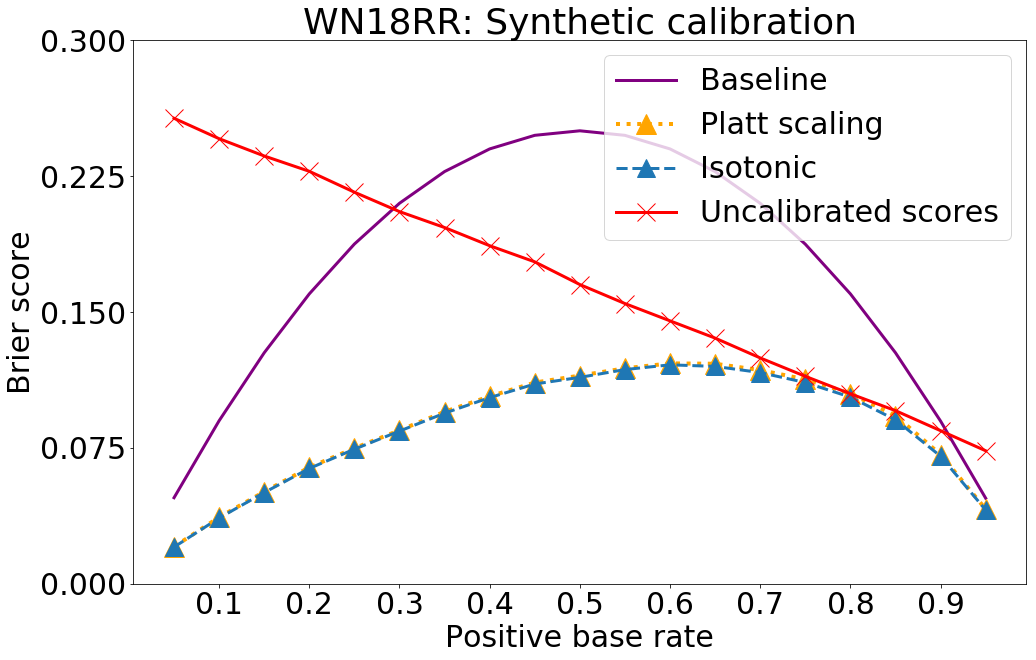

In [75]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 30, 'axes.titlesize': 36})
plt.plot(bs.index, bs.baseline, "-", lw=3, label="Baseline",
         fillstyle='full', color='purple', markersize=18)
plt.plot(bs.index, bs.probas_pos, "^:",lw=4, label="Platt scaling",  
         fillstyle='full', color='orange', markersize=20)
plt.plot(bs.index, bs.probas_pos_iso, "^--",  lw=3, label="Isotonic", 
         fillstyle='full', color='tab:blue', markersize=18)
plt.plot(bs.index, bs.scores, "x-",lw=3,  
         fillstyle='full', color='r', markersize=18,
         label="Uncalibrated scores")

plt.xlabel("Positive base rate")
plt.ylabel("Brier score")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.yticks(np.linspace(0, 0.3, 5))
plt.title("WN18RR: Synthetic calibration")

In [50]:
ll = df[(c for c in df.columns if c.startswith('log_loss'))]
ll.columns = [c[len("log_loss_"):] for c in ll.columns]
ll.style.apply(highlight_min, axis=1)

,baseline,probas_pos,probas_pos_iso,probas_pos_sc,scores
0.05,0.198515,0.0996867,0.0931016,0.0955278,0.713062
0.1,0.325083,0.160768,0.152259,0.154384,0.68418
0.15,0.422714,0.211039,0.199617,0.203668,0.65985
0.2,0.500402,0.251014,0.240322,0.243013,0.636024
0.25,0.562335,0.278717,0.270474,0.272438,0.604209
0.3,0.610882,0.300126,0.295308,0.295751,0.57416
0.35,0.647454,0.327162,0.320584,0.321644,0.55088
0.4,0.673012,0.353766,0.342317,0.346742,0.528683
0.45,0.68815,0.366135,0.357217,0.359751,0.502964
0.5,0.693147,0.370178,0.362829,0.365125,0.470326


Text(0.5, 1.0, 'WN18RR: Synthetic calibration')

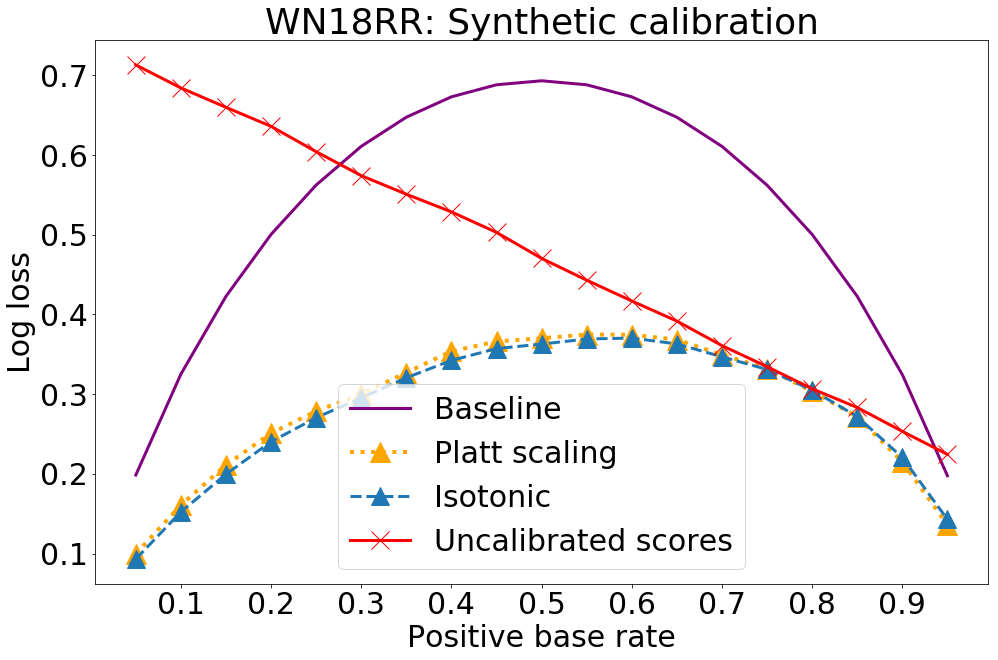

In [73]:
plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 30, 'axes.titlesize': 36})
plt.plot(ll.index, ll.baseline, "-", lw=3, label="Baseline",
         fillstyle='full', color='purple', markersize=18)
plt.plot(ll.index, ll.probas_pos, "^:",lw=4, label="Platt scaling",  
         fillstyle='full', color='orange', markersize=20)
plt.plot(ll.index, ll.probas_pos_iso, "^--",  lw=3, label="Isotonic", 
         fillstyle='full', color='tab:blue', markersize=18)
plt.plot(ll.index, ll.scores, "x-",lw=3,  
         fillstyle='full', color='r', markersize=18,
         label="Uncalibrated scores")

plt.xlabel("Positive base rate")
plt.ylabel("Log loss")
plt.legend()
plt.xticks(np.linspace(0.1, 0.9, 9))
plt.title("WN18RR: Synthetic calibration")